In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from numpy import linalg as ln
from netCDF4 import Dataset  
import pandas as pd
from scipy.stats import pearsonr
from sklearn.decomposition import TruncatedSVD
from sklearn.impute import SimpleImputer   

In [3]:
# Load the uploaded NetCDF file
file_path = "/Users/yl3699/Documents/EAS6995/sst_1980_2019.nc"
ds = xr.open_dataset(file_path)
ds


<xarray.Dataset> Size: 124MB
Dimensions:  (lat: 180, lon: 360, time: 480)
Coordinates:
  * lat      (lat) float32 720B 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 4kB 1980-01-01 1980-02-01 ... 2019-12-01
Data variables:
    sst      (time, lat, lon) float32 124MB ...
Attributes:
    title:            created 12/2013 from data provided by JRA
    history:          Created 12/2012 from data obtained from JRA by ESRL/PSD
    platform:         Analyses
    citation:         Hirahara, S., Ishii, M., and Y. Fukuda,2014: Centennial...
    institution:      NOAA ESRL/PSD
    Conventions:      CF-1.2
    dataset_title:    COBE-SST2 Sea Surface Temperature and Ice
    original_source:  https://climate.mri-jma.go.jp/pub/ocean/cobe-sst2/
    References:       http://www.psl.noaa.gov/data/gridded/cobe2.html

In [4]:
# Extract SST data
sst = ds['sst']

# Compute latitude weights: W(s) = sqrt(cos(phi))
latitudes = np.deg2rad(ds['lat'])  # Convert to radians
weights = np.sqrt(np.cos(latitudes))

# Expand dimensions to match (time, lat, lon) structure
weights_3d = weights.broadcast_like(sst)

# Compute the mean seasonal cycle (monthly climatology)
monthly_climatology = sst.groupby('time.month').mean(dim='time')

# Remove the seasonal cycle by subtracting the climatology
sst_deseasonalized = sst.groupby('time.month') - monthly_climatology

# Apply latitude weighting after deseasonalization
sst_weighted = sst_deseasonalized * weights_3d

# Handle missing values by linear interpolation
sst_weighted = sst_weighted.interpolate_na(dim='time', method='linear')

# Reshape into a 2D matrix: (time, lat*lon)
time_steps = sst_weighted.sizes['time']
lat_size = sst_weighted.sizes['lat']
lon_size = sst_weighted.sizes['lon']

sst_matrix = sst_weighted.values.reshape(time_steps, lat_size * lon_size)

# Convert to DataFrame and display
sst_df = pd.DataFrame(sst_matrix)
sst_df

,0,1,2,3,4,5,6,7,8,9,...,64790,64791,64792,64793,64794,64795,64796,64797,64798,64799
0,-0.001049,-0.001049,-0.001053,-0.000885,-0.000920,-0.000897,-0.000974,-0.000950,-0.000913,-0.000883,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.000864,-0.000871,-0.000908,-0.001205,-0.001016,-0.000953,-0.000694,-0.000855,-0.000845,-0.000810,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.001032,-0.001044,-0.001154,-0.001112,-0.000990,-0.000944,-0.000918,-0.000899,-0.000890,-0.000845,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.000845,-0.000859,-0.001011,-0.000979,-0.000958,-0.000745,-0.000698,-0.000869,-0.000855,-0.000855,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.001058,-0.000993,-0.000993,-0.000983,-0.000946,-0.000768,-0.000745,-0.000822,-0.000778,-0.000705,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,0.025255,0.024519,0.025222,0.025057,0.025652,0.026091,0.026145,0.025881,0.026056,0.025554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
476,0.028153,0.027663,0.028048,0.027854,0.028326,0.028803,0.028550,0.028578,0.028781,0.028275,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
477,0.010738,0.010750,0.010771,0.010897,0.010937,0.010836,0.010974,0.010820,0.010855,0.010818,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
478,0.003328,0.003480,0.003384,0.003244,0.003291,0.003242,0.003330,0.003333,0.003214,0.003239,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Center the data (subtract mean)
sst_centered = sst_matrix - np.nanmean(sst_matrix, axis=0)

# Replace NaNs with the column mean for numerical stability
imputer = SimpleImputer(strategy="mean")
sst_imputed = imputer.fit_transform(sst_centered)

# Perform Truncated SVD (keeping top 10 components)
n_components = 10
svd = TruncatedSVD(n_components=n_components, random_state=42)
pc_scores_svd = svd.fit_transform(sst_imputed)

# Extract eigenvalues from singular values
eigenvalues_truncated = svd.singular_values_**2 / (sst_imputed.shape[0] - 1)

# Compute explained variance
explained_variance_truncated = eigenvalues_truncated / np.sum(eigenvalues_truncated)
cumulative_variance_truncated = np.cumsum(explained_variance_truncated)

# Display the EOF results
eof_results_truncated = pd.DataFrame({
    "Singular Value": svd.singular_values_,
    "Eigenvalue": eigenvalues_truncated,
    "Explained Variance": explained_variance_truncated,
    "Cumulative Variance": cumulative_variance_truncated
})

eof_results_truncated

/var/folders/bp/92qg79yj5zq7738cnqbpbx000000gn/T/ipykernel_74994/309274195.py:2: RuntimeWarning: Mean of empty slice
  sst_centered = sst_matrix - np.nanmean(sst_matrix, axis=0)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: [ 2799  2800  2801 ... 64797 64798 64799]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


,Singular Value,Eigenvalue,Explained Variance,Cumulative Variance
0,921.888611,1774.276855,0.295714,0.295714
1,876.280334,1603.063110,0.267178,0.562892
2,541.627747,612.443909,0.102074,0.664967
3,430.712555,387.292938,0.064549,0.729516
4,402.161194,337.648499,0.056275,0.785791
5,389.217255,316.263214,0.052711,0.838502
6,362.132507,273.778595,0.045630,0.884132
7,346.895813,251.224854,0.041871,0.926003
8,330.707458,228.324478,0.038054,0.964057
9,321.404114,215.658875,0.035943,1.000000


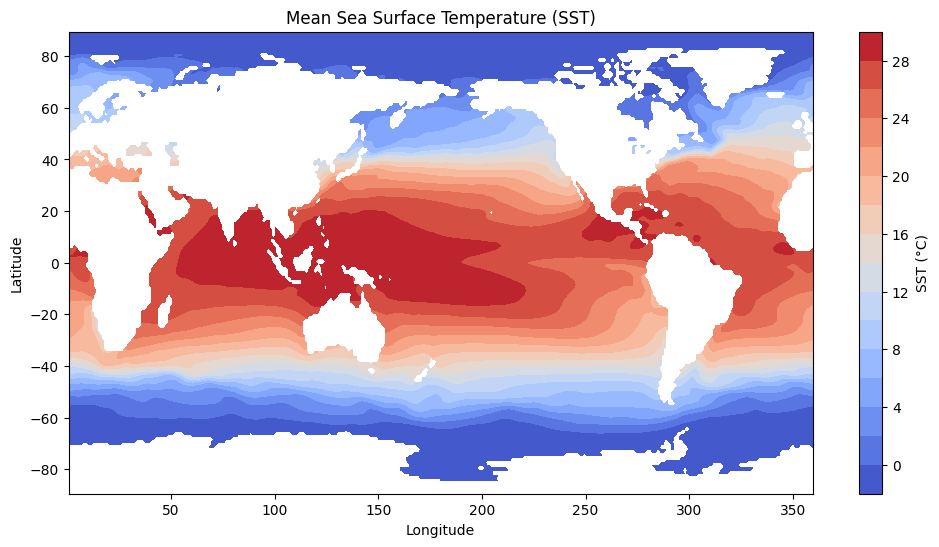

In [6]:
# Compute and plot the mean state map
mean_sst = sst.mean(dim='time')

plt.figure(figsize=(12, 6))
plt.contourf(ds['lon'], ds['lat'], mean_sst, cmap='coolwarm', levels=20)
plt.colorbar(label="SST (°C)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Mean Sea Surface Temperature (SST)")
plt.show()

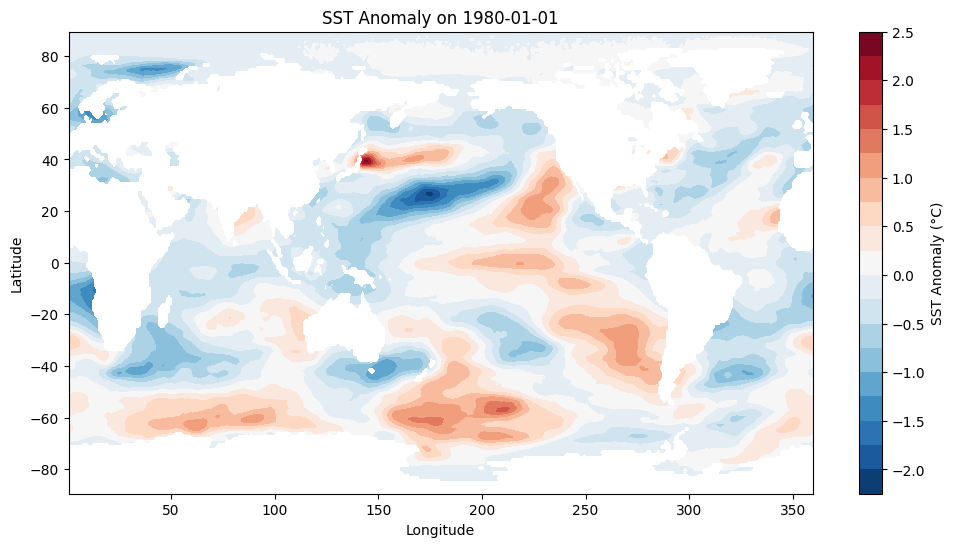

In [7]:

# Compute the mean seasonal cycle (monthly climatology)
monthly_climatology = sst.groupby('time.month').mean(dim='time')

# Compute SST anomalies by subtracting the climatology
sst_anomaly = sst.groupby('time.month') - monthly_climatology

# Select a specific time slice for visualization (e.g., first available time)
time_index = 0  # Change this to select different time steps
sst_anomaly_snapshot = sst_anomaly.isel(time=time_index)

# Plot the SST anomaly
plt.figure(figsize=(12, 6))
plt.contourf(ds['lon'], ds['lat'], sst_anomaly_snapshot, cmap='RdBu_r', levels=20)
plt.colorbar(label="SST Anomaly (°C)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"SST Anomaly on {str(sst_anomaly_snapshot['time'].values)[:10]}")
plt.show()


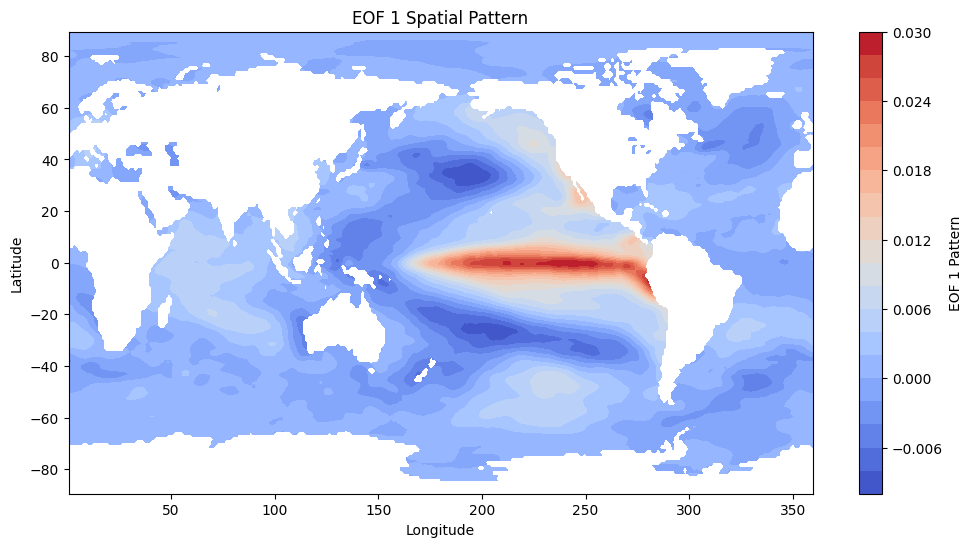

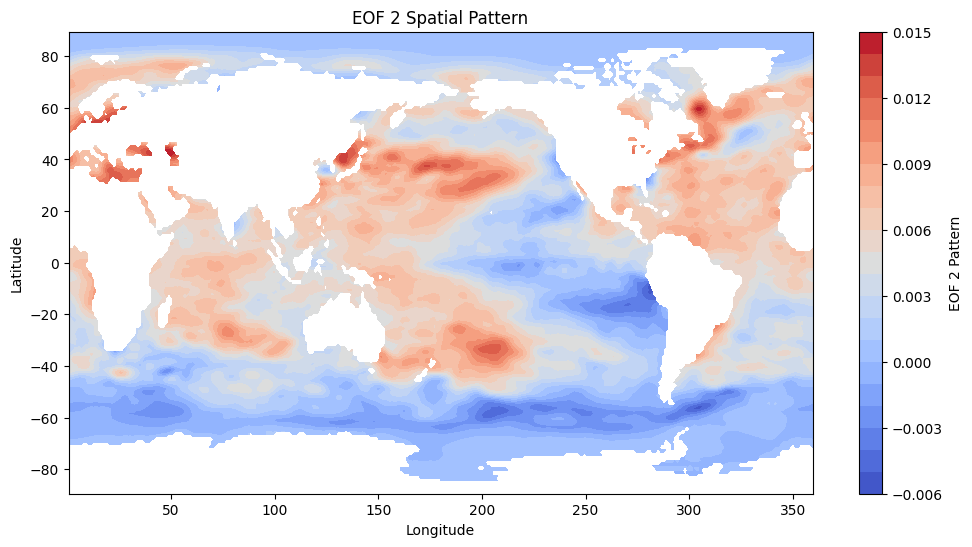

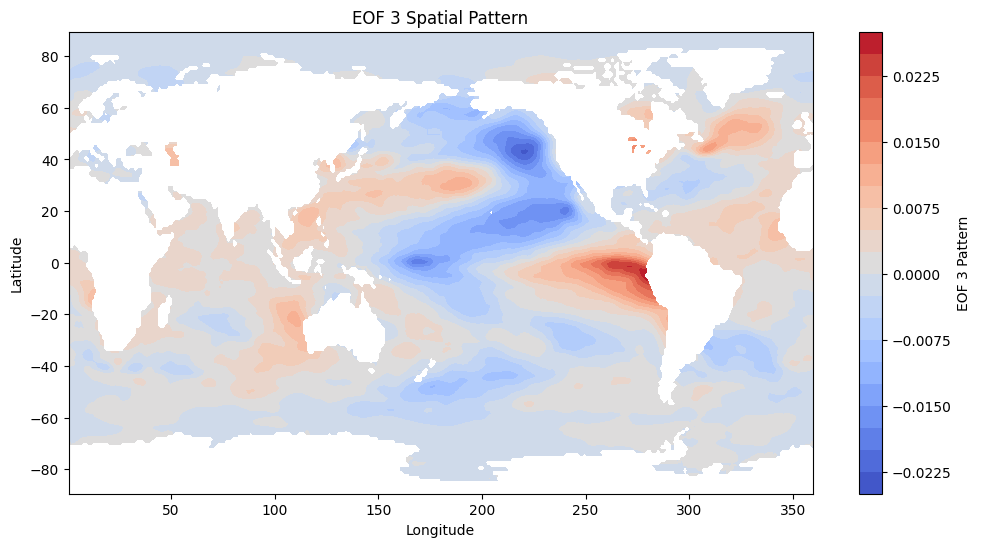

<Figure size 640x480 with 0 Axes>

In [8]:
# Ensure the reshaping matches the expected spatial dimensions
lat_size, lon_size = len(ds['lat']), len(ds['lon'])

# Identify valid spatial indices (non-NaN columns in sst_matrix)
valid_mask = ~np.all(np.isnan(sst_matrix), axis=0)
valid_indices = np.where(valid_mask)[0]

# Create an empty (lat, lon) grid for mapping
eof_patterns_full = np.full((3, lat_size, lon_size), np.nan)

# Fill valid locations with EOF values
for i in range(3):
    eof_map = np.full((lat_size * lon_size,), np.nan)
    eof_map[valid_indices] = svd.components_[i]  # Assign EOF values
    eof_patterns_full[i] = eof_map.reshape(lat_size, lon_size)  # Reshape

# PC time series for first 3 components
pc_time_series = pc_scores_svd[:, :3]

# Plot EOF Patterns
for i in range(3):
    plt.figure(figsize=(12, 6))
    plt.contourf(ds['lon'], ds['lat'], eof_patterns_full[i], cmap="coolwarm", levels=20)
    plt.colorbar(label=f"EOF {i+1} Pattern")
    plt.title(f"EOF {i+1} Spatial Pattern")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
plt.suptitle("First Three EOF Patterns of SST")
plt.tight_layout()
plt.show()


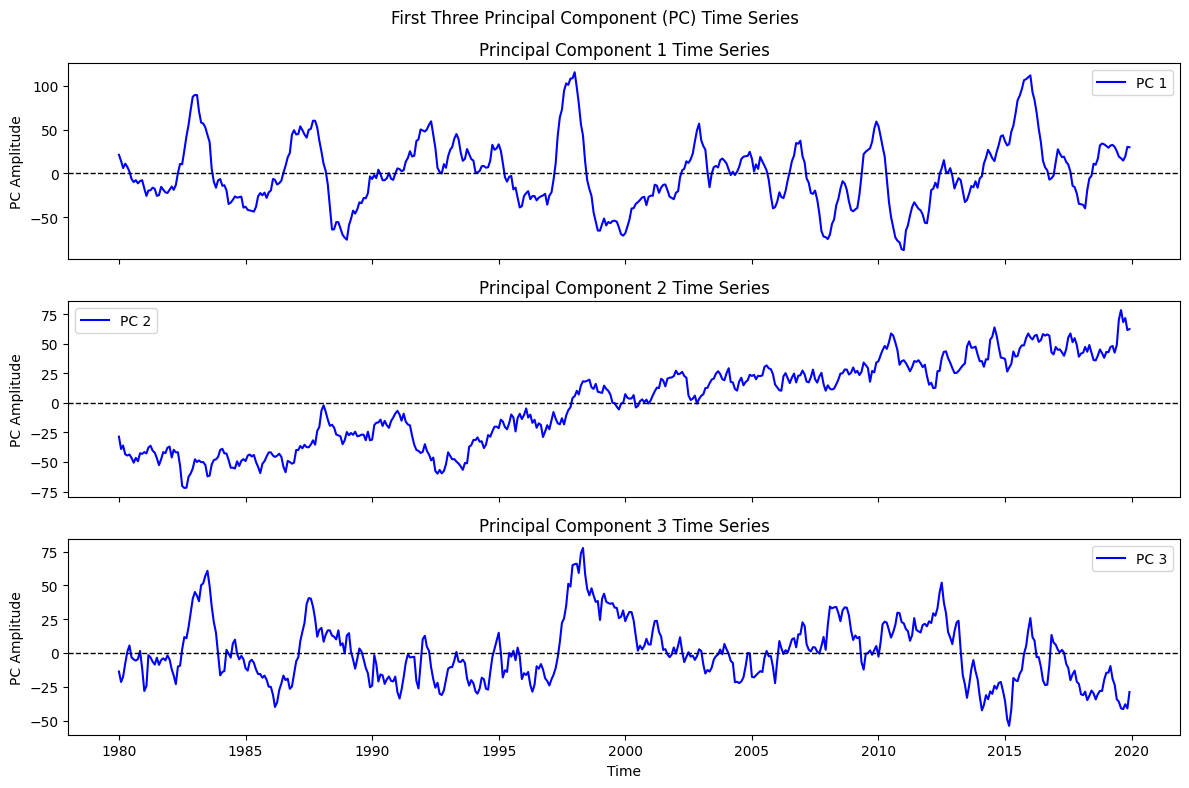

In [9]:
# Extract time variable
time = ds['time'].values  # Get the time dimension for plotting

# Plot the first three PC time series
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

for i in range(3):
    ax = axes[i]
    ax.plot(time, pc_scores_svd[:, i], label=f"PC {i+1}", color='b')
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.set_ylabel("PC Amplitude")
    ax.set_title(f"Principal Component {i+1} Time Series")
    ax.legend()

axes[-1].set_xlabel("Time")
plt.suptitle("First Three Principal Component (PC) Time Series")
plt.tight_layout()
plt.show()


/var/folders/bp/92qg79yj5zq7738cnqbpbx000000gn/T/ipykernel_74994/370768213.py:16: RuntimeWarning: Mean of empty slice
  sst_centered = sst_matrix - np.nanmean(sst_matrix, axis=0)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: [ 2799  2800  2801 ... 64797 64798 64799]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


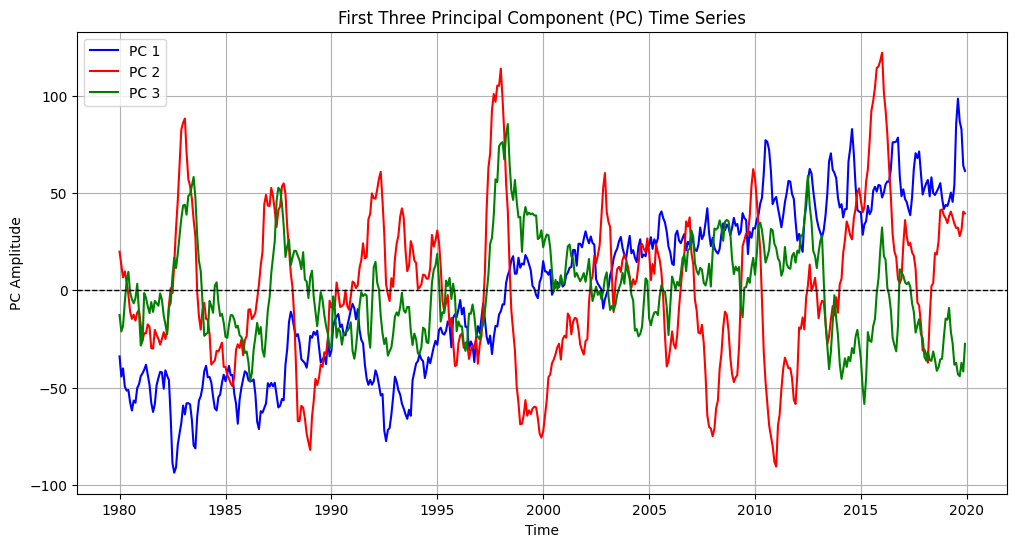

In [13]:
# Compute the mean seasonal cycle (monthly climatology)
monthly_climatology = sst.groupby('time.month').mean(dim='time')

# Remove the seasonal cycle
sst_deseasonalized = sst.groupby('time.month') - monthly_climatology

# Get dataset dimensions
time_steps = sst_deseasonalized.sizes['time']
lat_size = sst_deseasonalized.sizes['lat']
lon_size = sst_deseasonalized.sizes['lon']

# Reshape into a 2D matrix: (time, spatial points)
sst_matrix = sst_deseasonalized.values.reshape(time_steps, -1)

# Center the data (subtract mean)
sst_centered = sst_matrix - np.nanmean(sst_matrix, axis=0)

# Replace NaNs with the column mean
imputer = SimpleImputer(strategy="mean")
sst_imputed = imputer.fit_transform(sst_centered)

# Perform Truncated SVD (EOF analysis)
n_components = 3  # Compute first 3 EOFs
svd = TruncatedSVD(n_components=n_components, random_state=42)
pc_scores_svd = svd.fit_transform(sst_imputed)

# Extract time variable
time = ds['time'].values  # Get the time dimension for plotting

# Plot all three PC time series in one figure
plt.figure(figsize=(12, 6))

plt.plot(time, pc_scores_svd[:, 0], label="PC 1", color='b')
plt.plot(time, pc_scores_svd[:, 1], label="PC 2", color='r')
plt.plot(time, pc_scores_svd[:, 2], label="PC 3", color='g')

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Time")
plt.ylabel("PC Amplitude")
plt.title("First Three Principal Component (PC) Time Series")
plt.legend()
plt.grid(True)
plt.show()


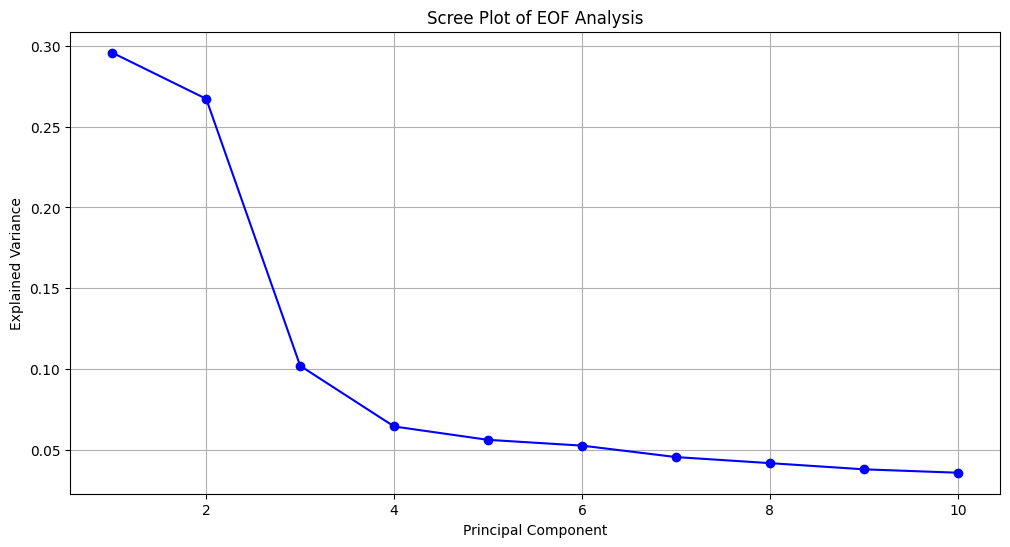

In [15]:
# Compute explained variance for each component
eigenvalues_truncated = svd.singular_values_**2 / (sst_imputed.shape[0] - 1)
explained_variance_truncated = eigenvalues_truncated / np.sum(eigenvalues_truncated)

# Create Scree Plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, n_components + 1), explained_variance_truncated, marker='o', linestyle='-', color='b')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
plt.title("Scree Plot of EOF Analysis")
plt.grid(True)
plt.show()

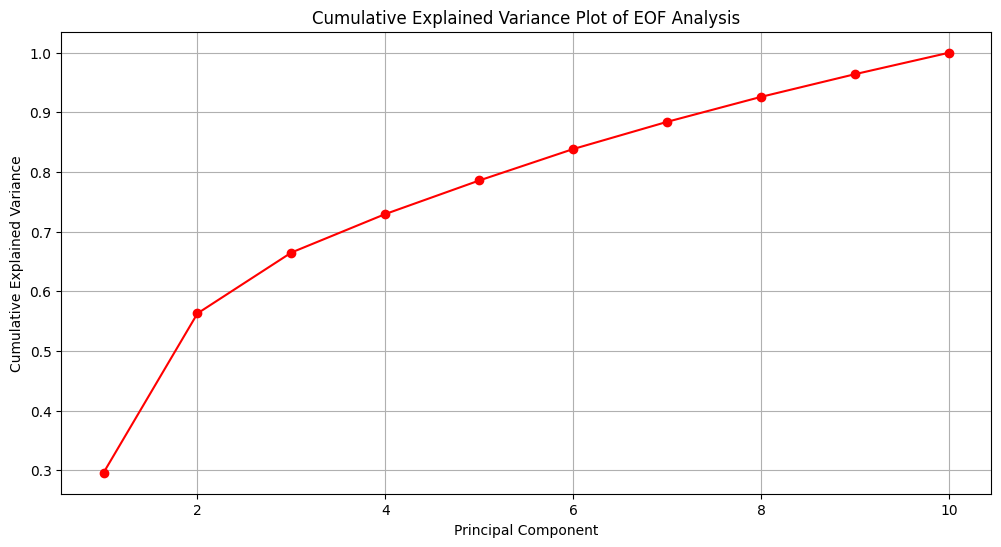

In [16]:
# Compute cumulative explained variance
cumulative_variance_truncated = np.cumsum(explained_variance_truncated)

# Create cumulative explained variance plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, n_components + 1), cumulative_variance_truncated, marker='o', linestyle='-', color='r')
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance Plot of EOF Analysis")
plt.grid(True)
plt.show()

In [16]:
# Load the ONI (Niño index) data
oni_file = "/Users/yl3699/Documents/EAS6995/oni.data.txt"

# Read the file and extract ONI values
with open(oni_file, "r") as file:
    lines = file.readlines()

# Extract numeric values from the ONI data
oni_data = []
years = []
for line in lines:
    parts = line.split()
    if len(parts) == 13:  # Expected format: Year followed by 12 monthly values
        try:
            year = int(parts[0])
            values = [float(v) for v in parts[1:]]
            years.append(year)
            oni_data.extend(values)
        except ValueError:
            continue  # Skip lines that are not formatted correctly

# Convert ONI data into a DataFrame
oni_years = np.repeat(years, 12)  # Repeat each year for 12 months
oni_months = np.tile(np.arange(1, 13), len(years))  # Create a sequence of months
oni_df = pd.DataFrame({"Year": oni_years, "Month": oni_months, "ONI": oni_data})

# Extract PC1, PC2, and PC3
pc1 = pc_scores_svd[:, 0]
pc2 = pc_scores_svd[:, 1]
pc3 = pc_scores_svd[:, 2]

# Standardize the PC values
pc1_std = (pc1 - np.mean(pc1)) / np.std(pc1)
pc2_std = (pc2 - np.mean(pc2)) / np.std(pc2)
pc3_std = (pc3 - np.mean(pc3)) / np.std(pc3)

# Match ONI time range with PC time range (assuming dataset starts in 1980)
start_year = 1980
end_year = start_year + len(pc1_std) // 12  # Estimate end year
oni_filtered = oni_df[(oni_df["Year"] >= start_year) & (oni_df["Year"] < end_year)]

# Ensure we have the same number of time points
time_length = min(len(oni_filtered), len(pc1_std))
oni_filtered = oni_filtered.iloc[:time_length]
pc1_std = pc1_std[:time_length]
pc2_std = pc2_std[:time_length]
pc3_std = pc3_std[:time_length]

# Compute correlation coefficients
r_pc1 = np.corrcoef(oni_filtered["ONI"], pc1_std)[0, 1]
r_pc2 = np.corrcoef(oni_filtered["ONI"], pc2_std)[0, 1]
r_pc3 = np.corrcoef(oni_filtered["ONI"], pc3_std)[0, 1]

# Create correlation DataFrame
correlation_df = pd.DataFrame({
    "PC": ["PC1", "PC2", "PC3"],
    "Correlation with Niño Index": [r_pc1, r_pc2, r_pc3]
})
correlation_df


,PC,Correlation with Niño Index
0,PC1,-0.161053
1,PC2,0.925591
2,PC3,0.043802


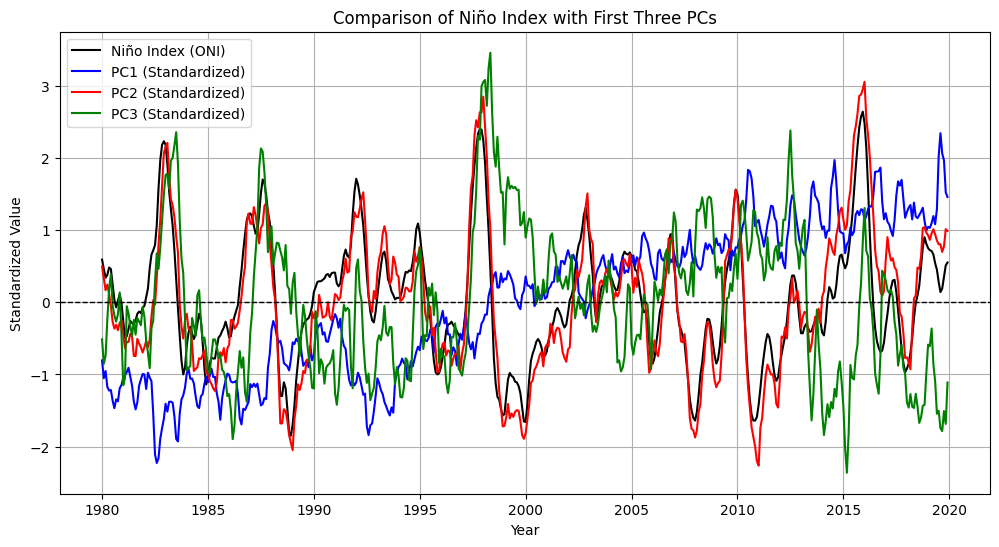

In [17]:
# Plot the comparison between ONI and standardized PC values
plt.figure(figsize=(12, 6))
plt.plot(oni_filtered["Year"] + (oni_filtered["Month"] - 1) / 12, oni_filtered["ONI"], label="Niño Index (ONI)", color='black')
plt.plot(oni_filtered["Year"] + (oni_filtered["Month"] - 1) / 12, pc1_std, label="PC1 (Standardized)", color='b')
plt.plot(oni_filtered["Year"] + (oni_filtered["Month"] - 1) / 12, pc2_std, label="PC2 (Standardized)", color='r')
plt.plot(oni_filtered["Year"] + (oni_filtered["Month"] - 1) / 12, pc3_std, label="PC3 (Standardized)", color='g')

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Year")
plt.ylabel("Standardized Value")
plt.title("Comparison of Niño Index with First Three PCs")
plt.legend()
plt.grid(True)
plt.show()